In [1]:
# ============================================
# 1) Imports & paths  (LOCAL NOTEBOOK VERSION)
# ============================================
import os
import math
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Modern AMP API (PyTorch >= 2.0)
from torch.amp import autocast, GradScaler

# ---------- EDIT THIS PART ----------
# Full path to your local H5 databank:
H5_PATH     = r"F:\20251115\spectra_h5\common_proteoform.h5"   # <-- change this
H5_DATASET  = "ms2_lib"                                        # dataset name in H5

# Where to save outputs (check this exists or will be created):
OUT_DIR     = r"F:\20251125\diffusion_out"                     # <-- change if you want

# -----------------------------------
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP       = (DEVICE == "cuda")
USE_TORCH_COMPILE = False   # turn ON for long runs, OFF for quick tests

BATCH_SIZE    = 256         # UNet is heavier than MLP; tweak if OOM
NUM_EPOCHS    = 10          # increase for better quality (e.g. 30+)
LR            = 2e-4
NUM_TIMESTEPS = 10          # can increase later to 50–100
SPECTRUM_LEN  = 1600        # bins from 400–2000 m/z (1 amu)

NUM_SAMPLES       = 32      # how many synthetic spectra to generate
MAX_TRAIN_SPECTRA = 5120    # randomly choose this many from H5 (None = all)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

os.makedirs(OUT_DIR, exist_ok=True)

print("H5 path:", H5_PATH)
print("Output dir:", OUT_DIR)
print("Device:", DEVICE, "| USE_AMP:", USE_AMP)

# ============================================
# 3) Dataset (RANDOM SUBSET + improved normalization)
# ============================================
class MS2H5Dataset(Dataset):
    """
    Lazily reads spectra from local H5 and returns normalized 1D spectra.
    Normalization:
      - per-spectrum TIC: x = x / sum(x)
      - sqrt compression: x = sqrt(x)
      - map [0,1] -> [-1,1] for diffusion
    """
    def __init__(self, h5_path, dataset_name, max_spectra=None, seed=42):
        super().__init__()
        self.h5_path = h5_path
        self.dataset_name = dataset_name

        self.h5 = h5py.File(self.h5_path, "r")
        self.ds = self.h5[self.dataset_name]
        full_len = self.ds.shape[0]

        if (max_spectra is None) or (max_spectra >= full_len):
            self.indices = np.arange(full_len)
        else:
            rng = np.random.default_rng(seed=seed)
            self.indices = rng.choice(full_len, size=max_spectra, replace=False)

        self.length = len(self.indices)

        print(f"Loaded dataset '{dataset_name}' from H5.")
        print("Full shape:", self.ds.shape)
        print(f"Randomly selected {self.length} spectra for training.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        x = self.ds[real_idx].astype(np.float32)   # (SPECTRUM_LEN,)

        # TIC normalization
        tic = x.sum()
        if tic > 0:
            x = x / tic

        # sqrt compression (better dynamic range)
        x = np.sqrt(x)

        # map [0,1] -> [-1,1]
        x = x * 2.0 - 1.0

        return torch.from_numpy(x)

    def close(self):
        if self.h5 is not None:
            self.h5.close()
            self.h5 = None

# ============================================
# 4) Diffusion utils (x0-prediction)
# ============================================
def make_beta_schedule(T, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, T)

class Diffusion:
    """
    Standard DDPM with model predicting x0 (clean spectrum).
    """
    def __init__(self, T, device):
        self.T = T
        self.device = device

        betas = make_beta_schedule(T).to(device)   # (T,)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.betas = betas
        self.alphas = alphas
        self.alphas_cumprod = alphas_cumprod
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=device), alphas_cumprod[:-1]], dim=0
        )

        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
        self.posterior_var = betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - alphas_cumprod)

    def q_sample(self, x0, t, noise=None):
        """
        Forward diffusion q(x_t | x_0)
        x0: (B, D) in [-1,1]
        t:  (B,) int in [0,T-1]
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise

    def p_sample(self, model, x_t, t):
        """
        One reverse step p(x_{t-1} | x_t) using model that predicts x0.
        """
        betas_t = self.betas[t].view(-1, 1)
        alphas_t = self.alphas[t].view(-1, 1)
        alphas_cumprod_t = self.alphas_cumprod[t].view(-1, 1)
        alphas_cumprod_prev_t = self.alphas_cumprod_prev[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)

        # model predicts x0 directly
        x0_pred = model(x_t, t).clamp(-1.0, 1.0)

        # posterior mean μ_t
        posterior_mean = (
            betas_t * torch.sqrt(alphas_cumprod_prev_t) / (1.0 - alphas_cumprod_t) * x0_pred
            + (torch.sqrt(alphas_t) * (1.0 - alphas_cumprod_prev_t) / (1.0 - alphas_cumprod_t)) * x_t
        )

        posterior_var_t = self.posterior_var[t].view(-1, 1)
        if (t == 0).all():
            return posterior_mean

        noise = torch.randn_like(x_t)
        return posterior_mean + torch.sqrt(posterior_var_t) * noise

    def p_sample_loop(self, model, shape):
        """
        Draw x_T ~ N(0,I) and iteratively sample to x_0.
        """
        model.eval()
        x_t = torch.randn(shape, device=self.device)
        with torch.no_grad():
            for time_step in reversed(range(self.T)):
                t_tensor = torch.full((shape[0],), time_step, device=self.device, dtype=torch.long)
                x_t = self.p_sample(model, x_t, t_tensor)
        return x_t

# ============================================
# 5) Time embedding + UNet-1D model
# ============================================
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t: (B,) integer timesteps
        returns: (B, dim)
        """
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb

class ResBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, kernel_size=3, groups=8):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding)
        self.norm1 = nn.GroupNorm(groups, out_ch)
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act = nn.SiLU()

        self.time_proj = nn.Linear(time_dim, out_ch)
        self.skip = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        """
        x: (B, C, L)
        t_emb: (B, time_dim)
        """
        h = self.conv1(x)
        # add time embedding
        t = self.time_proj(t_emb).unsqueeze(-1)   # (B, out_ch, 1)
        h = h + t
        h = self.act(self.norm1(h))

        h = self.conv2(h)
        h = self.act(self.norm2(h))

        return h + self.skip(x)

class UNet1D(nn.Module):
    """
    1D U-Net for spectra with time conditioning.
    Input:  x_t (B, D), t (B,)
    Output: x0_pred (B, D)
    """
    def __init__(self, data_dim, time_dim=128, base_ch=64):
        super().__init__()
        self.data_dim = data_dim

        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        # Encoder
        self.in_conv = nn.Conv1d(1, base_ch, 3, padding=1)
        self.enc1 = ResBlock1D(base_ch,   base_ch,   time_dim)
        self.down1 = nn.Conv1d(base_ch,   base_ch*2, 4, stride=2, padding=1)

        self.enc2 = ResBlock1D(base_ch*2, base_ch*2, time_dim)
        self.down2 = nn.Conv1d(base_ch*2, base_ch*4, 4, stride=2, padding=1)

        self.enc3 = ResBlock1D(base_ch*4, base_ch*4, time_dim)

        # Bottleneck
        self.mid = ResBlock1D(base_ch*4, base_ch*4, time_dim)

        # Decoder
        self.up2 = nn.ConvTranspose1d(base_ch*4, base_ch*2, 4, stride=2, padding=1)
        self.dec2 = ResBlock1D(base_ch*4, base_ch*2, time_dim)

        self.up1 = nn.ConvTranspose1d(base_ch*2, base_ch, 4, stride=2, padding=1)
        self.dec1 = ResBlock1D(base_ch*2, base_ch, time_dim)

        self.out_conv = nn.Conv1d(base_ch, 1, 3, padding=1)

    def forward(self, x, t):
        """
        x: (B, D) in [-1,1]
        t: (B,) timesteps
        """
        # prepare shapes
        x = x.unsqueeze(1)   # (B,1,L)
        t_emb = self.time_mlp(t)  # (B, time_dim)

        # Encoder
        x0 = self.in_conv(x)
        e1 = self.enc1(x0, t_emb)
        d1 = self.down1(e1)

        e2 = self.enc2(d1, t_emb)
        d2 = self.down2(e2)

        e3 = self.enc3(d2, t_emb)

        # Bottleneck
        m = self.mid(e3, t_emb)

        # Decoder
        u2 = self.up2(m)
        u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2, t_emb)

        u1 = self.up1(d2)
        u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1, t_emb)

        out = self.out_conv(d1)      # (B,1,L)
        out = out.squeeze(1)         # (B,L)
        return out

# ============================================
# 6) Training (UNet + x0 prediction)
# ============================================
def train():
    dataset = MS2H5Dataset(
        H5_PATH,
        H5_DATASET,
        max_spectra=MAX_TRAIN_SPECTRA,
        seed=SEED,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        drop_last=True,
        pin_memory=(DEVICE == "cuda"),
    )

    model = UNet1D(SPECTRUM_LEN).to(DEVICE)

    if USE_TORCH_COMPILE:
        try:
            model = torch.compile(model)
            print("Using torch.compile for model.")
        except Exception as e:
            print("torch.compile not used:", e)

    diffusion = Diffusion(NUM_TIMESTEPS, DEVICE)
    scaler = GradScaler(device="cuda", enabled=USE_AMP)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    loss_log = []
    global_step = 0

    print("\n========== START TRAINING ==========\n")
    print(f"Device: {DEVICE}")
    print(f"Total spectra in file: {dataset.ds.shape[0]:,}")
    print(f"Using spectra for training: {len(dataset):,}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Steps per epoch: {len(dataloader)}")
    print(f"Timesteps (T): {NUM_TIMESTEPS}")
    print("--------------------------------------\n")

    for epoch in range(NUM_EPOCHS):
        print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")
        epoch_loss = []

        for batch_i, batch in enumerate(dataloader):
            batch = batch.to(DEVICE, non_blocking=True)   # x0 in [-1,1]

            if batch_i == 0 or (batch_i + 1) % 50 == 0:
                print(f"[Epoch {epoch+1}] Batch {batch_i+1}/{len(dataloader)} "
                      f"| global step {global_step}")

            # sample random timesteps
            t = torch.randint(
                0, NUM_TIMESTEPS,
                (batch.size(0),),
                device=DEVICE
            ).long()

            # forward diffusion
            noise = torch.randn_like(batch)
            with autocast(device_type="cuda", enabled=USE_AMP):
                x_t = diffusion.q_sample(batch, t, noise)
                x0_pred = model(x_t, t)
                loss = nn.functional.mse_loss(x0_pred, batch)

            epoch_loss.append(loss.item())
            loss_log.append(loss.item())

            optimizer.zero_grad(set_to_none=True)
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            global_step += 1

            if global_step % 200 == 0:
                print(f"[Epoch {epoch+1} | Step {batch_i+1}/{len(dataloader)} "
                      f"| Global {global_step}] Loss: {loss.item():.6f}")

        mean_epoch_loss = float(np.mean(epoch_loss))
        print(f"Epoch {epoch+1} done. Mean loss: {mean_epoch_loss:.6f}")

    # Save final checkpoint
    ckpt_path = os.path.join(OUT_DIR, "diffusion_unet_final.pt")
    torch.save({
        "model_state_dict": model.state_dict(),
        "epoch": NUM_EPOCHS,
    }, ckpt_path)
    print(f"Saved final checkpoint: {ckpt_path}")

    # Loss curve
    plt.figure(figsize=(8, 4))
    plt.plot(loss_log, alpha=0.8)
    plt.xlabel("Training step")
    plt.ylabel("MSE loss (x0 prediction)")
    plt.title("Diffusion Training Loss (UNet-1D)")
    plt.tight_layout()
    loss_plot_path = os.path.join(OUT_DIR, "loss_curve_unet.png")
    plt.savefig(loss_plot_path, dpi=150)
    plt.close()
    print("Saved loss plot to:", loss_plot_path)

    dataset.close()
    return model, diffusion, loss_log

# ============================================
# 7) Sampling + saving outputs
# ============================================
def sample_and_save(model, diffusion, num_samples=NUM_SAMPLES):
    model.to(DEVICE)
    model.eval()

    # generate in [-1,1]
    samples = diffusion.p_sample_loop(
        model,
        shape=(num_samples, SPECTRUM_LEN)
    )

    # map [-1,1] -> [0,1]
    samples = (samples.clamp(-1, 1) + 1.0) / 2.0
    samples = samples.cpu().numpy().astype(np.float32)

    # optional: renormalize each spectrum to max=1
    max_vals = samples.max(axis=1, keepdims=True)
    max_vals[max_vals == 0] = 1.0
    samples = samples / max_vals

    out_npy = os.path.join(OUT_DIR, "synthetic_ms2.npy")
    np.save(out_npy, samples)
    print("Saved synthetic spectra to:", out_npy)

    # quick visualization (overlay 5)
    mz_axis = np.linspace(400, 2000, SPECTRUM_LEN, endpoint=False)
    plt.figure(figsize=(10, 6))
    for i in range(min(5, num_samples)):
        plt.plot(mz_axis, samples[i], alpha=0.7)
    plt.xlabel("m/z")
    plt.ylabel("normalized intensity")
    plt.title("Synthetic MS2 spectra from UNet diffusion")
    plt.tight_layout()
    out_png = os.path.join(OUT_DIR, "synthetic_ms2_unet.png")
    plt.savefig(out_png, dpi=200)
    plt.close()
    print("Saved synthetic plot to:", out_png)

# ============================================
# 8) Run training + sampling
# ============================================
model, diffusion, loss_log = train()
sample_and_save(model, diffusion, NUM_SAMPLES)
print("All done. Outputs saved in:", OUT_DIR)


H5 path: F:\20251115\spectra_h5\common_proteoform.h5
Output dir: F:\20251125\diffusion_out
Device: cpu | USE_AMP: False
Loaded dataset 'ms2_lib' from H5.
Full shape: (778, 1600)
Randomly selected 778 spectra for training.

========== START TRAINING ==========

Device: cpu
Total spectra in file: 778
Using spectra for training: 778
Batch size: 256
Steps per epoch: 3
Timesteps (T): 10
--------------------------------------


===== Epoch 1/10 =====
[Epoch 1] Batch 1/3 | global step 0
Epoch 1 done. Mean loss: 0.361129

===== Epoch 2/10 =====
[Epoch 2] Batch 1/3 | global step 3
Epoch 2 done. Mean loss: 0.040752

===== Epoch 3/10 =====
[Epoch 3] Batch 1/3 | global step 6
Epoch 3 done. Mean loss: 0.020088

===== Epoch 4/10 =====
[Epoch 4] Batch 1/3 | global step 9
Epoch 4 done. Mean loss: 0.010105

===== Epoch 5/10 =====
[Epoch 5] Batch 1/3 | global step 12
Epoch 5 done. Mean loss: 0.011852

===== Epoch 6/10 =====
[Epoch 6] Batch 1/3 | global step 15
Epoch 6 done. Mean loss: 0.007189

===== Ep

plotting synthetic data

Loaded synthetic spectra: (32, 1600)

=== 5) 4x4 GRID ===


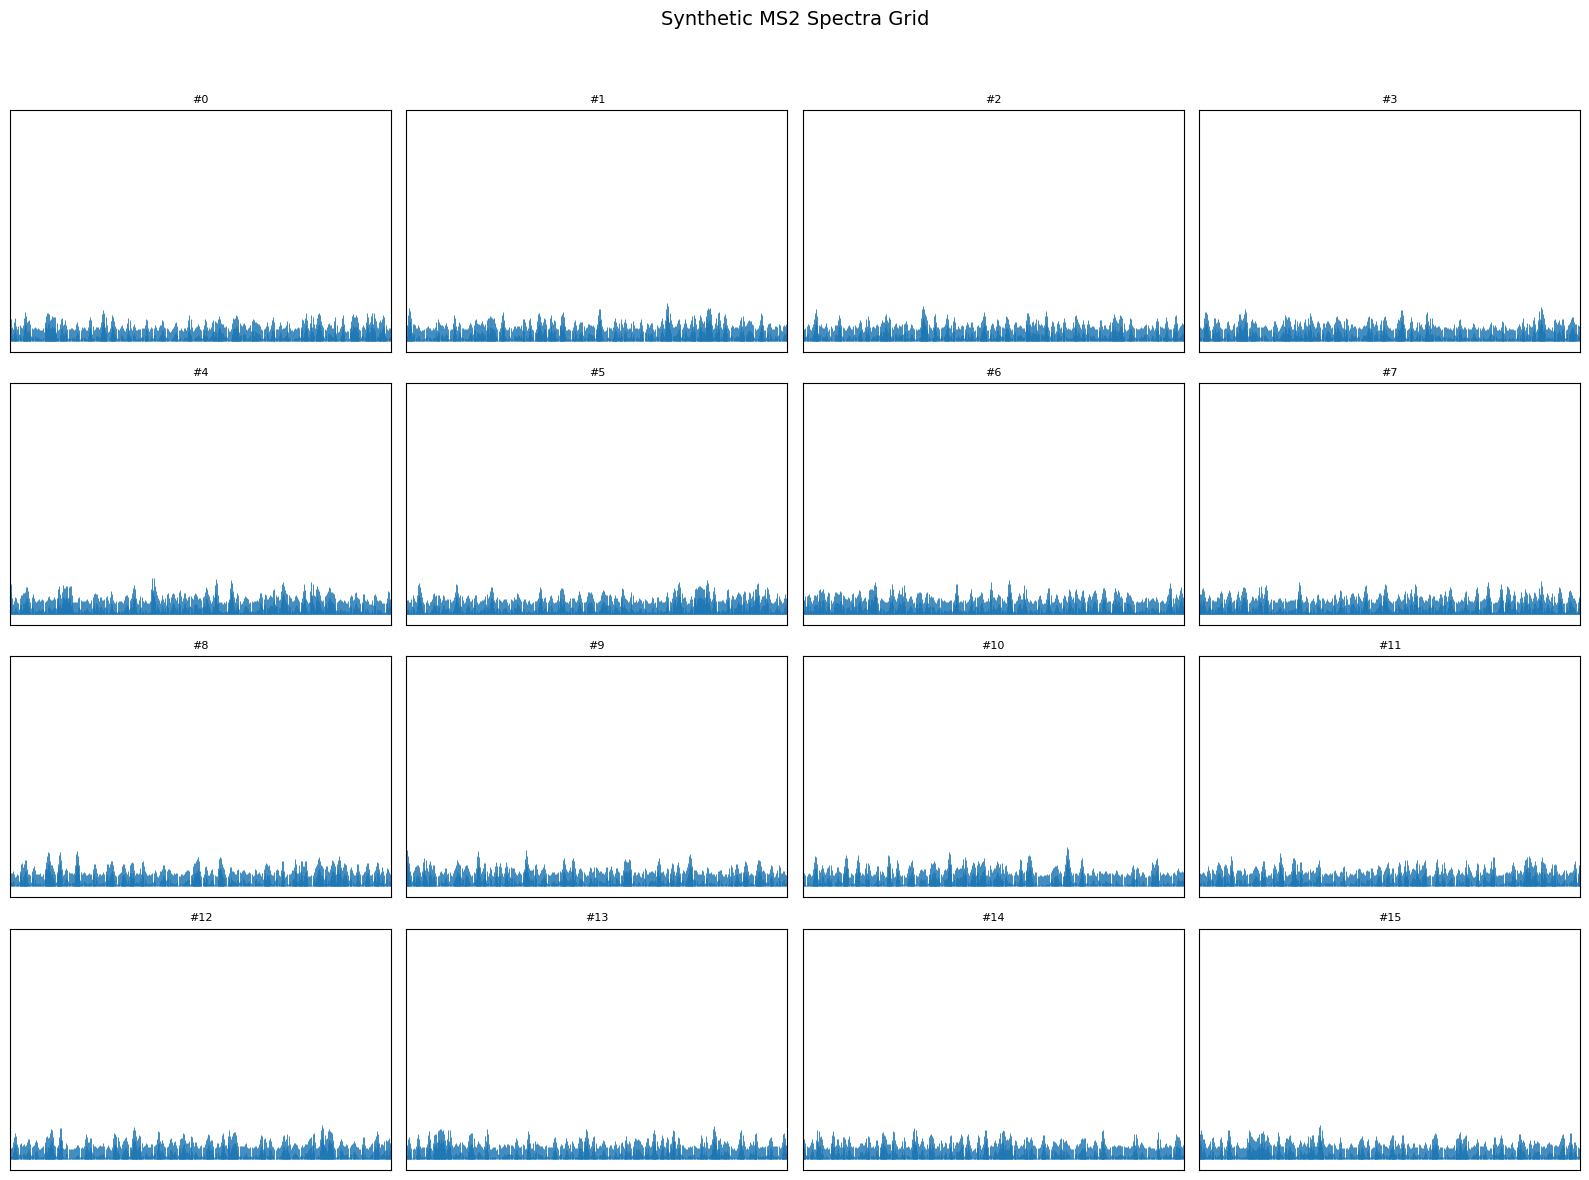

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ================================
# Load Synthetic Spectra
# ================================
SYNTH_PATH = r"F:\20251125\diffusion_out/synthetic_ms2.npy"
samples = np.load(SYNTH_PATH)       # Shape: (N, 1600)
print("Loaded synthetic spectra:", samples.shape)

# m/z bins: 400 → 2000 (1600 points)
mz_axis = np.linspace(400, 2000, samples.shape[1], endpoint=False)

# =========================================================
# 5. 4×4 GRID OF SYNTHETIC SPECTRA
# =========================================================
def plot_grid(num_rows=4, num_cols=4):
    num_to_plot = min(samples.shape[0], num_rows * num_cols)
    plt.figure(figsize=(16, 12))

    for i in range(num_to_plot):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.vlines(mz_axis, 0, samples[i], linewidth=0.6)
        ax.set_title(f"#{i}", fontsize=8)
        ax.set_xlim(500, 1900)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.autoscale(enable=True, axis='y')

    plt.suptitle("Synthetic MS2 Spectra Grid", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# =========================================================
# --- RUN VISUALIZATIONS ---
# =========================================================

print("\n=== 5) 4x4 GRID ===")
plot_grid()

